In [1]:
# OG jawn = https://github.com/franciscojavierarceo/Python/blob/master/Step%20Functions.ipynb

%load_ext autoreload
%autoreload 2
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import math
import seaborn
import itertools 
import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation
from keras.regularizers import l2, activity_l2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from matplotlib import cm
%matplotlib inline

Using TensorFlow backend.


# Generating synthetic data from a step function in two variables

In [3]:
x1 = np.arange(-100,100)
x2 = np.arange(-100,100)
xs = np.asarray(list(itertools.product(x1,x2)))
ys = np.zeros( (len(xs),))

# This defines our function (i.e., f(x) = y)
clist = [-75, -50, -25, 25, 50, 75]
olist = [10, 25, 50, 75, 100]
for c, o in zip(clist, olist):
    flt = (xs[:,0]> c) & (xs[:,1] > c)
    ys[np.where(flt),] = o

# Plotting the true step function

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


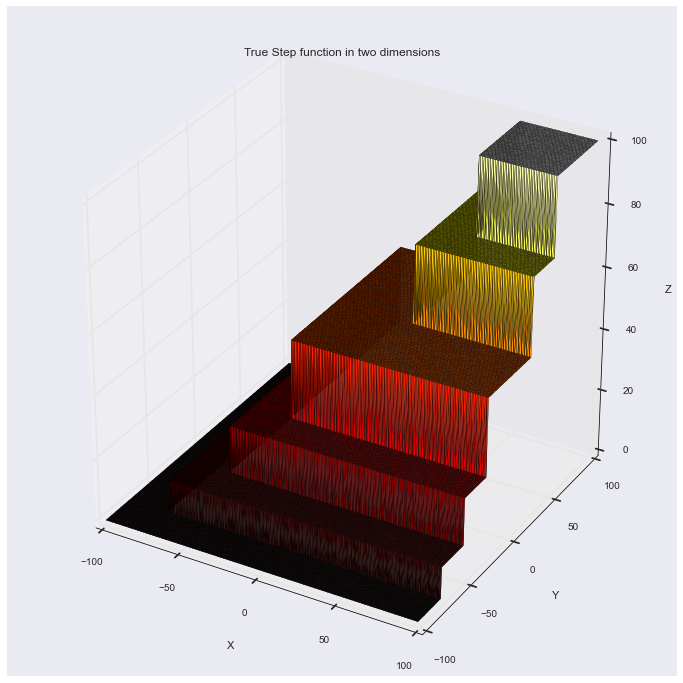

In [4]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(xs[:,0], xs[:,1], ys, cmap=cm.hot)
ax.set_title('True Step function in two dimensions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Learning a GBM

In [5]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.5, random_state=420)

estimator = GradientBoostingRegressor(
    n_estimators=1000,
    max_features='auto',
    random_state=420,
    verbose=1,
    learning_rate=0.3499135
)
estimator.fit(X_train, y_train)
yprd_tst = estimator.predict(X_test)
err = yprd_tst - y_test

      Iter       Train Loss   Remaining Time 
         1         420.6900            3.88s
         2         221.4624            3.44s
         3         109.8056            3.47s
         4          69.2129            3.45s
         5          32.9684            3.29s
         6          17.4801            3.27s
         7          10.7669            3.26s
         8           6.8760            3.31s
         9           5.0845            3.28s
        10           4.3003            3.28s
        20           1.3727            3.10s
        30           0.5743            3.15s
        40           0.2901            3.15s
        50           0.1915            3.09s
        60           0.1359            3.08s
        70           0.1061            3.05s
        80           0.0810            3.03s
        90           0.0660            3.00s
       100           0.0535            2.93s
       200           0.0146            2.49s
       300           0.0074            2.15s
       40

# Learning a NN with a different activation function

In [16]:
nhidden = 1
n_neurons = 10
model = Sequential()

afunc = 'relu'
# Initial layer
model.add(Dense(n_neurons, input_dim=X_train.shape[-1], activation=afunc))

# Creating nhidden number of layers 
for i in range(nhidden):
    model.add(Dense(n_neurons,
                    input_dim=n_neurons,
                    activation=afunc,
                    W_regularizer=l2(0.01),
                    activity_regularizer=activity_l2(0.01)
                   )
             )

model.add(Dense(
        6,
        input_dim=n_neurons,
        activation='softmax')
         )
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop'
#     metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, pd.get_dummies(y_train).values,
          nb_epoch=200, batch_size=50,
          validation_data=(X_test, pd.get_dummies(y_test).values),
          callbacks=[early_stopping],
          verbose=1)

yprd_tstnn = model.predict(X_test).argmax(axis=1)
olist_d = dict(zip(range(1, 6), olist))
yprd_tstnn = [olist_d.get(yi, 0) for yi in yprd_tstnn]
errnn = yprd_tstnn - y_test

Train on 20000 samples, validate on 20000 samples
Epoch 1/200
20000/20000 [==============================] - 7s - loss: 5.3899 - val_loss: 0.9961
Epoch 2/200
20000/20000 [==============================] - 7s - loss: 1.0238 - val_loss: 0.7570
Epoch 3/200
20000/20000 [==============================] - 7s - loss: 0.8186 - val_loss: 0.6177
Epoch 4/200
20000/20000 [==============================] - 7s - loss: 0.6874 - val_loss: 0.5253
Epoch 5/200
20000/20000 [==============================] - 7s - loss: 0.5879 - val_loss: 0.4301
Epoch 6/200
20000/20000 [==============================] - 7s - loss: 0.5125 - val_loss: 0.3640
Epoch 7/200
20000/20000 [==============================] - 7s - loss: 0.4573 - val_loss: 0.3189
Epoch 8/200
20000/20000 [==============================] - 7s - loss: 0.4150 - val_loss: 0.2833
Epoch 9/200
20000/20000 [==============================] - 7s - loss: 0.3835 - val_loss: 0.2580
Epoch 10/200
20000/20000 [==============================] - 7s - loss: 0.3593 - val_lo

In [7]:
[(lyr.input_dim, lyr.output_dim) for lyr in model.layers], X_train.shape

([(2, 5), (5, 5), (5, 5), (5, 6)], (20000, 2))

In [15]:
rmse_gbm = np.sqrt( ((yprd_tst - y_test)**2).sum())
rmse_nns = np.sqrt( ((yprd_tstnn - y_test)**2).sum())

print("The RMSE of the GBM is %0.3f" % rmse_gbm)
print("The RMSE of the NN is %0.3f" % rmse_nns)

print("The GBM/NN RMSE = %0.3f" % (rmse_gbm / rmse_nns) )

The RMSE of the GBM is 5.981
The RMSE of the NN is 459.837
The GBM/NN RMSE = 0.013


# Learning the NN

In [9]:
nhidden = 10
n_neurons = 200
model = Sequential()

# Initial layer
model.add(Dense(n_neurons, input_dim=2, activation='relu'))

# Creating nhidden number of layers 
for i in range(nhidden):
    model.add(Dense(n_neurons, activation='relu', W_regularizer=l2(0.01),
                    activity_regularizer=activity_l2(0.01)))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train,
          nb_epoch=200, batch_size=50,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping])

yprd_tstnn = model.predict(X_test)[:,0]
errnn = yprd_tstnn - y_test

TypeError: cost must be a scalar.

# Plotting the learned function and the residuals in 3d


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


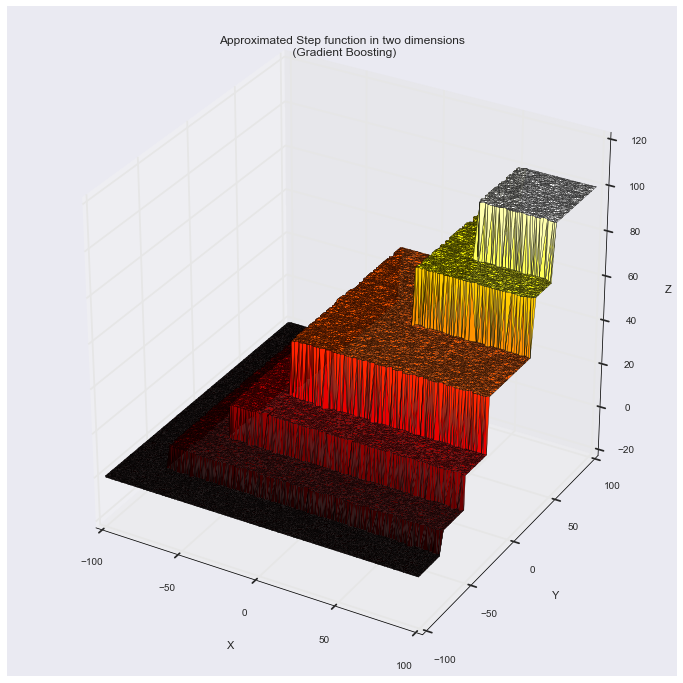

In [9]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], yprd_tst, cmap=cm.hot)
ax.set_title('Approximated Step function in two dimensions \n (Gradient Boosting)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [10]:
rmse_gbm = np.sqrt( ((yprd_tst - y_test)**2).sum())
rmse_nns = np.sqrt( ((yprd_tstnn - y_test)**2).sum())

print("The RMSE of the GBM is %0.3f" % rmse_gbm)
print("The RMSE of the NN is %0.3f" % rmse_nns)

print("The GBM/NN RMSE = %0.3f" % (rmse_gbm / rmse_nns) )

The RMSE of the GBM is 5.981
The RMSE of the NN is 513.079
The GBM/NN RMSE = 0.012


/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


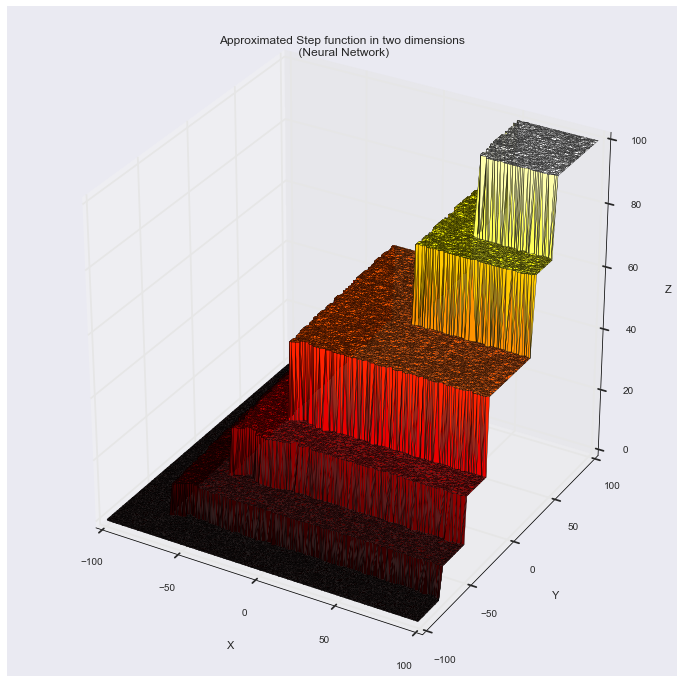

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], yprd_tstnn, cmap=cm.hot)
ax.set_title('Approximated Step function in two dimensions \n (Neural Network)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

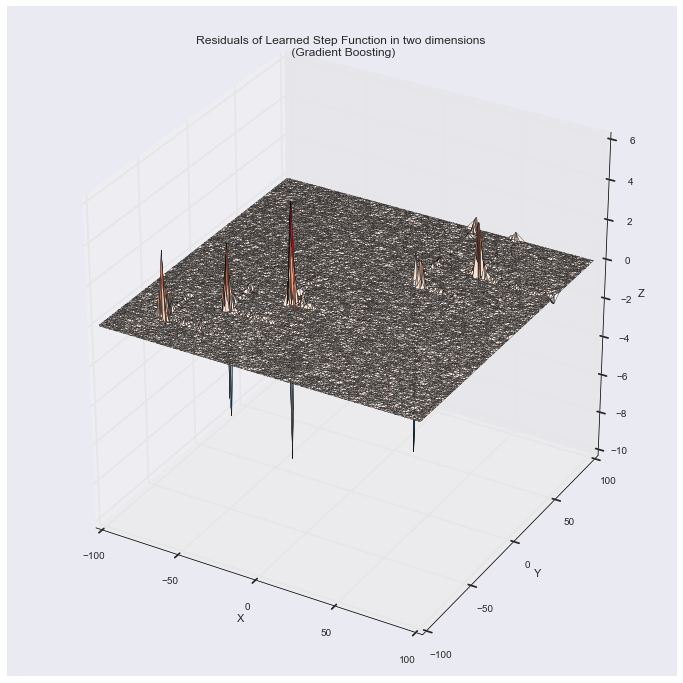

In [28]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], err, cmap=cm.RdBu_r)
ax.set_title('Residuals of Learned Step Function in two dimensions \n (Gradient Boosting)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


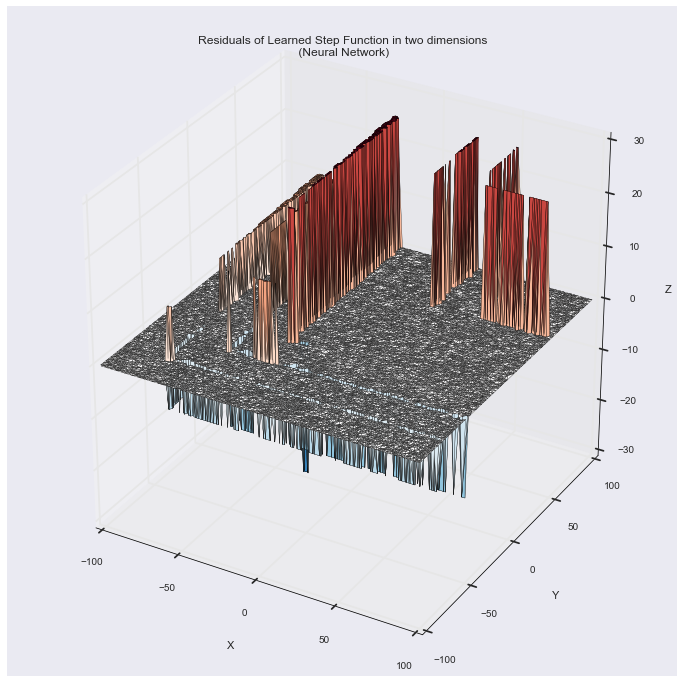

In [12]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X_test[:,0], X_test[:,1], errnn, cmap=cm.RdBu_r)
ax.set_title('Residuals of Learned Step Function in two dimensions \n (Neural Network)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()